In [7]:
from fink_utils.sso.periods import estimate_synodic_period # v0.21.0 or more
import requests
import time
import io

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

In [2]:
bft_source = "local" # choose `net` to download it

cols = [
    'sso_number', 'sso_name', 'sso_class',
    'spins.1.period.value', 'spins.2.period.value',
]

if bft_source == "local":
    # Local Configuration
    bft_file = '/tmp/ssoBFT-latest.parquet' 
    bft = pd.read_parquet(bft_file, columns=cols)
elif bft_source == 'net':
    r = requests.get("https://ssp.imcce.fr/data/ssoBFT-latest_Asteroid.parquet")
    bft = pd.read_parquet(io.BytesIO(r.content), columns=cols)
    bft.to_parquet("/tmp/ssoBFT-latest.parquet")

## Period estimation

In [3]:
flavor = "SHG1G2"
ssnamenr = 5209
period_range = (1 / 24, 7) # 1hour to 7 days

t0 = time.time()
period, chi2red, frequency, power, model, pdf = estimate_synodic_period(
    ssnamenr, flavor=flavor, Nterms_base=1, period_range=period_range, return_extra_info=True
)

print(
    "[{:.2f} seconds] model={}: period={:.2f} hours (chi2red={:.2f}) -- BFT: period={:.2f} hours".format(
        time.time() - t0,
        flavor,
        period,
        chi2red,
        bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0]
    )
)

[16.76 seconds] model=SHG1G2: period=5.80 hours (chi2red=0.76) -- BFT: period=11.60 hours


## Residuals

Text(0, 0.5, 'Residual (mag)')

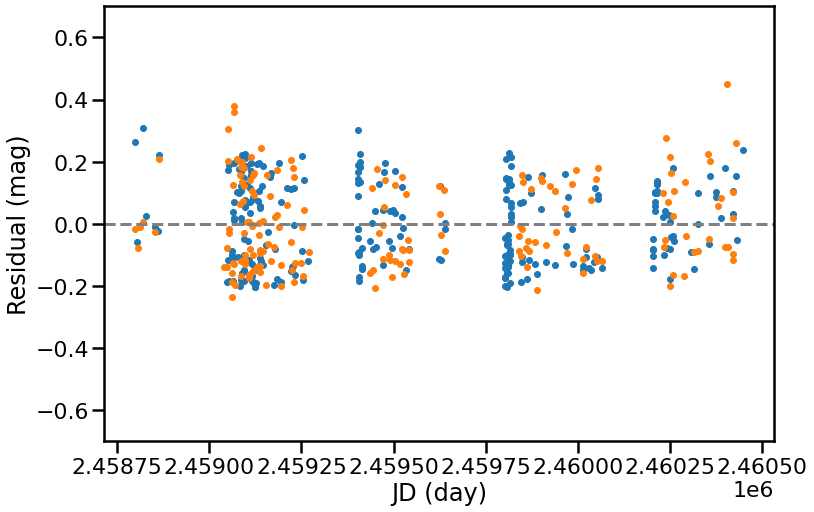

In [4]:
fig = plt.figure(figsize=(12, 8))

for filtnum in pdf["i:fid"].unique():
    cond = pdf['i:fid'] == filtnum
    plt.plot(pdf['i:jd'][cond], pdf["residuals"][cond], ls="", marker='.')
plt.axhline(0, ls="--", color="grey")
plt.ylim(-0.7, 0.7)
plt.xlabel("JD (day)")
plt.ylabel("Residual (mag)")

## Folding

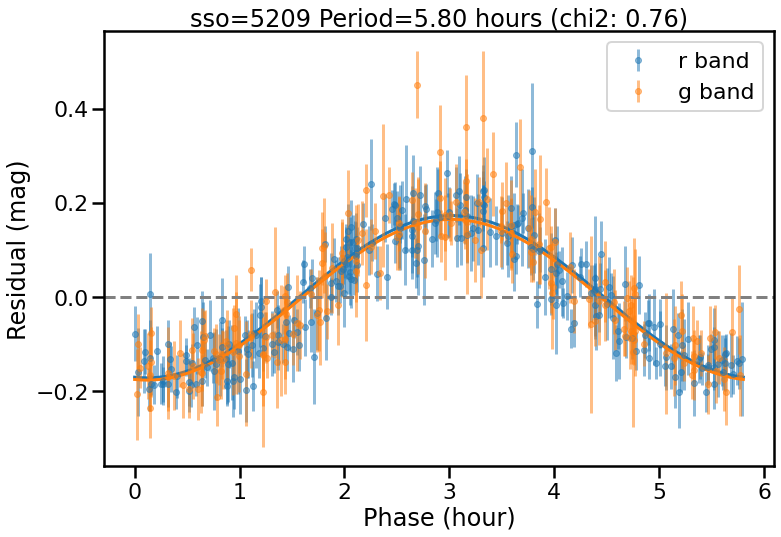

In [5]:
fig = plt.figure(figsize=(12, 8))

tfit = np.linspace(0, period/24, 100)
magfit = model.model(tfit, 1/period*24)
colors = ["C0", "C1"]
dicband = {1: "g", 2: "r"}
for index, (color, filtnum) in enumerate(zip(colors, pdf["i:fid"].unique())):
    cond = pdf['i:fid'] == filtnum    
    phase = pdf["i:jd"][cond] % (period/24)
    plt.errorbar(
        phase*24, 
        pdf["residuals"][cond], 
        pdf['i:sigmapsf'][cond], 
        ls="", marker='.', alpha=0.5, color=color, label="{} band".format(dicband[filtnum])
    )
    plt.plot(tfit*24, magfit[index], ls="-", marker='', color=color)
plt.axhline(0, ls="--", color="grey")
# plt.ylim(-0.7, 0.7)
plt.title("sso={} Period={:.2f} hours (chi2: {:.2f})".format(ssnamenr, period, chi2red))
plt.xlabel("Phase (hour)")
plt.ylabel("Residual (mag)")
plt.legend();

## Periodogram

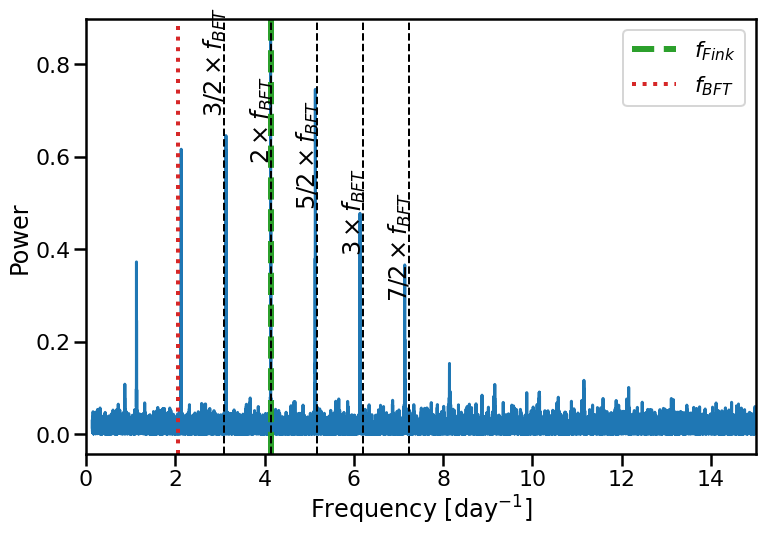

In [8]:
period_bft = bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0]

fig = plt.figure(figsize=(12, 8))
plt.plot(frequency, power)
plt.axvline(1/period*24, ls='--', lw=6, color='C2', label=r"$f_{Fink}$")
plt.axvline(1/period_bft * 24, ls=':', lw=4, color='C3', label=r"$f_{BFT}$")

offset = -0.5
offset_y = 0.1
plt.text(1/period_bft * 24 * 3/2 + offset, 0.7, r"$3/2 \times f_{BFT}$", rotation=90)
plt.text(1/period_bft * 24 * 2 + offset, 0.7 - offset_y, r"$2 \times f_{BFT}$", rotation=90)
plt.text(1/period_bft * 24 * 5/2 + offset, 0.7 - offset_y*2, r"$5/2 \times f_{BFT}$", rotation=90)
plt.text(1/period_bft * 24 * 3 + offset, 0.7  - offset_y*3, r"$3 \times f_{BFT}$", rotation=90)
plt.text(1/period_bft * 24 * 7/2 + offset, 0.7 - offset_y*4, r"$7/2 \times f_{BFT}$", rotation=90)

plt.axvline(1/period_bft * 24 * 3/2, ls='--', lw=2, color='black')
plt.axvline(1/period_bft * 24 * 2, ls='--', lw=2, color='black')
plt.axvline(1/period_bft * 24 * 5/2, ls='--', lw=2, color='black')
plt.axvline(1/period_bft * 24 * 3, ls='--', lw=2, color='black')
plt.axvline(1/period_bft * 24 * 7/2, ls='--', lw=2, color='black')

plt.xlim(0, 15)
plt.xlabel(r"Frequency [day$^{-1}$]")
plt.ylabel("Power")
plt.legend();